--------------------
--------------------

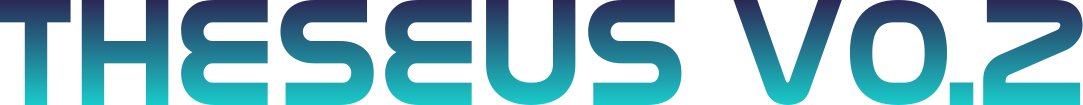

--------------------
--------------------

# Generating Position / Forecast Database (Input and Output) (v0.2)

### PROJECT THESEUS (v0.2) - PART 2
------------------

Artash Nath, UTAT Orbit Member

-------------------

This notebook loads a list of simulated keplarian coordinates and converts them to position, and forecasted prediction vectors. [X, Y, Z, V<sub>x</sub>, V<sub>y</sub>, V<sub>z</sub>].

The position vector is the current state of the sattelite, while the forcasted prediction is the state of the sattelite in a unit time.

This code produces 2 NPY files : the positions, and the forecasted position.

-------------------

<b>1. Importing Libraries</b>

In [1]:
from ctypes import CDLL, POINTER, c_double, c_void_p
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from multiprocessing import Process
import time

----------------------

<b>2. Load Kelparian Input Data</b>

In [2]:
kepl_elem_coordinates = np.load('./data/kepl_elem_coordinates.npy')

In [3]:
np.shape(kepl_elem_coordinates)

(45000000, 6)

----------

<b>3. Load C Library and Functions</b>

In [4]:
supernova = CDLL(("supernova.so"))
# Load library
# Make sure you have a supernova.so binary compiled for your system


def _wrap_func(lib, funcname, restype, argtypes):
    ''' Referenced from https://dbader.org/blog/python-ctypes-tutorial-part-2
    '''
    func = lib.__getattr__(funcname)
    func.restype = restype
    func.argtypes = argtypes
    return func


force_model = _wrap_func(
    supernova, "simplified_perturbations", None,
    [c_double, POINTER(c_double), POINTER(c_double)])

state_from_keplerian = _wrap_func(
    supernova, "stateFromKeplerian", POINTER(c_double),
    [c_double, c_double, c_double, c_double, c_double, c_double])

next_state = _wrap_func(
    supernova, "nextStatefromCurrent", POINTER(c_double),
    [c_double, c_double, c_double, c_double, c_double, c_double, c_double]
)

free = _wrap_func(supernova, "freemem", None, [c_void_p])
# Define functions from supernova C in Python


def get_state_and_acceleration(state: np.ndarray) -> \
        "tuple[np.ndarray, np.ndarray]":
    '''
    state: 6 keplerian elements presented as [SMA, ECC, INC, RAAN, AOP, MA]
    all distances in m
    all angles in radians
    '''
    rv = state_from_keplerian(*state)  # position/velocity vector
    result = (c_double*6)()  # place to store the resulting velocity/acceleration
    force_model(0, rv, result)

    py_rv = np.copy(np.ctypeslib.as_array(rv, shape=(6,)))
    py_result = np.copy(np.ctypeslib.as_array(result, shape=(6,)))
    free(rv)

    return py_rv, py_result


def get_state_and_next_state(state: np.ndarray, timestep) -> \
        "np.ndarray":
    '''
    state: 6 position/velocity state presented as [X, Y, Z, VX, VY, VZ]
    timestep: how many seconds forward to advance orbit (keep it less than 60 and more than 1)
    all distances in m
    '''
    next = next_state(*state, timestep)  # position/velocity vector
    py_next = np.copy(np.ctypeslib.as_array(next, shape=(6,)))

    free(next)

    return py_next

------------------

<b> 4. Generating Position and Effect Vectors from Simulated Keplarian Coordinate List </b>

In [5]:
position1_data = np.zeros(shape=(np.shape(kepl_elem_coordinates)))
position2_data = np.zeros(shape=(np.shape(kepl_elem_coordinates)))

i = 0

for coord in tqdm(kepl_elem_coordinates):
    position1, effect = get_state_and_acceleration(coord)
    timestep = 10
    position2 = get_state_and_next_state(position1, timestep)
    position1_data[i] = position1
    position2_data[i] = position2
    i+=1

  0%|          | 0/45000000 [00:00<?, ?it/s]

-----------------

<b>4. Saving Position and Effect Vectors to .NPY file</b>

In [6]:
np.save('./DATA/position_data1.npy', position1_data)
np.save('./DATA/position_data2.npy', position2_data)